## Final Project Submission

Please fill out:
* Student name: Kristen Davis 
* Student pace: Full Time
* Scheduled project review date/time: Monday October 19 - 11:30 am
* Instructor name: Rafael Carrasco
* Blog post URL:


# Data Cleaning 

## Workspace Set Up

In [6]:
 #library imports 
import pandas as pd  
#pip install pandasql
import pandasql
import numpy as np  

from statsmodels.formula.api import ols 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import statsmodels.api as sm
import scipy.stats as stats 
from sklearn.model_selection import train_test_split 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from itertools import combinations

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns   
import plotly.express as px

import warnings
warnings.filterwarnings('ignore') 

In [7]:
#Read in housing data & initialize it to a variable
raw_data_df = pd.read_csv("data/kc_house_data.csv") 

## Data Cleaning 

In [8]:
#explore inital dataset 
raw_data_df.info()   
# There are 21,597 Observations (each row is a house sale)
# Waterfront, view, year renovated have null values   
# Date is object  
# There are "?" in the 

len(raw_data_df[raw_data_df.duplicated()]) 
#0 all unique home sales 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

0

In [9]:
#looking at the nan values 
raw_data_df.isna().sum() 
#watefront 2,376/ 21,597 NAN 
#view 63/ 21,597 NAN 
#yr_renovated 3,842/21,597 NAN  

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [10]:
#replace NAN values with 0 
df = raw_data_df.fillna(0) 
df 

#veriying NAN values are gone
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [11]:
#change the date row to a datetime object 
df['date'] = pd.to_datetime(df['date'])

In [12]:
#looking at values in sqft_basement 
df['sqft_basement'].unique()
df = df.replace({'sqft_basement': {"?": 0.0}}) 

#set as float 
df['sqft_basement'] = df['sqft_basement'].astype('float64')

##### Data Decision Explaination: 
There are too many rows with NAN (particularly in the waterfront column) to drop without affecting the dataset, given that if all three of these coloumns are indicators that not every house would have, and opperating under the assumption that if the house did have any one of there three 'features' homeowners would be motivated to list them - I am going to replace all NaN with a 0 to indicate that the house does not have that feature.

In [15]:
%store df

Stored 'df' (DataFrame)


In [16]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Feature Engineering  
Additional features added to the data frame include: population density column 

### Creating a Population Density Feature
Based on the information gathered <a href="https://www.unitedstateszipcodes.org/98039/">here</a> I created a column that lists the population per square mile in 2015 by zipcode. This will be helpful in considering a model that is senstive to urban v rural areas.

In [17]:
#creating a dataframe of each zipcode & population density data from 2015 called pop_density_by_zip
zipcode = [98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039]
pop_density = [4966, 6879, 3606, 6425, 2411, 662, 3800, 4441, 5573, 469, 5684, 7018, 9602, 6732, 
               141, 9905, 4423, 6279, 3591, 892, 4741, 8638, 6667, 2908, 469, 7953, 2215, 1717, 4323, 
               3580, 4604, 288, 3194, 10643, 1537, 4437, 1725, 13594, 7895, 3977, 2361, 4428, 2185, 
               7523, 334, 6841, 4714, 2024, 41, 15829, 785, 2989, 3794, 3341, 171, 2719, 3402, 10361, 52,
               3696, 4330, 236, 3569, 4877, 4161, 1231, 3062, 149, 4585, 2059] 

lists = list(zip(zipcode, pop_density)) 
pop_density_by_zip = pd.DataFrame(lists, columns = ['zipcode', 'pop_density'])

In [18]:
#map population density onto the main dataframe as a new column called "pop_density"
dic = {zipcode[i]: pop_density[i] for i in range(len(zipcode))}  

def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 

event_dictionary = {98178: 4966, 98125: 6879, 98028: 3606, 98136: 6425, 98074: 2411, 98053: 662, 98003: 3800, 98198: 4441, 
                    98146: 5573, 98038: 469, 98007: 5684, 98115: 7018, 98107: 9602, 98126: 6732, 98019: 141, 98103: 9905,
                    98002: 4423, 98133: 6279, 98040: 3591, 98092: 892, 98030: 4741, 98119: 8638, 98112: 6667, 98052: 2908, 
                    98027: 469, 98117: 7953, 98058: 2215, 98001: 1717, 98056: 4323, 98166: 3580, 98023: 4604, 98070: 288, 
                    98148: 3194, 98105: 10643, 98042: 1537, 98008: 4437, 98059: 1725, 98122: 13594, 98144: 7895, 98004: 3977,
                    98005: 2361, 98034: 4428, 98075: 2185, 98116: 7523, 98010: 334, 98118: 6841, 98199: 4714, 98032: 2024, 
                    98045: 41, 98102: 15829, 98077: 785, 98108: 2989, 98168: 3794, 98177: 3341, 98065: 171, 98029: 2719, 
                    98006: 3402, 98109: 10361, 98022: 52, 98033: 3696, 98155: 4330, 98024: 236, 98011: 3569, 98031: 4877, 
                    98106: 4161, 98072: 1231, 98188: 3062, 98014: 149, 98055: 4585, 98039: 2059} 
df['pop_density'] = df['zipcode'].apply(set_value, args=(event_dictionary, )) 

In [19]:
#subdivide my dataframe by density into roughly equal sections 
low_density = df.loc[df['pop_density'] < 2500] 
med_density = df.loc[(df['pop_density'] > 2500) & (df['pop_density'] < 5000)] 
high_density = df.loc[df['pop_density'] > 5000]

# Categorical Data  
The following columns have data that I am going to treat as categorical: "zipcode", "yr_bui't" & "yr_renovated"

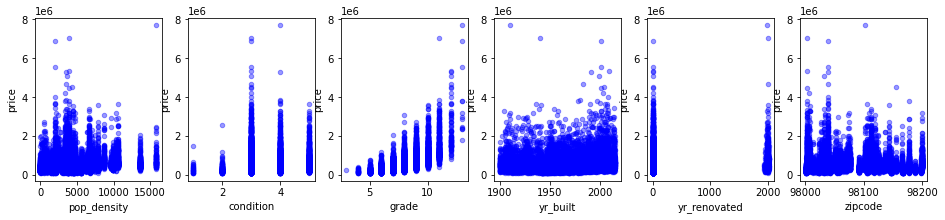

In [20]:
#create plot to visualize data types
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16,3)) 

all_cols =['pop_density', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 
           'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
           'sqft_living15', 'sqft_lot15']

for xcol, ax in zip(['pop_density', 'condition', 'grade', 'yr_built', 'yr_renovated', 'zipcode'], axes):
    df.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

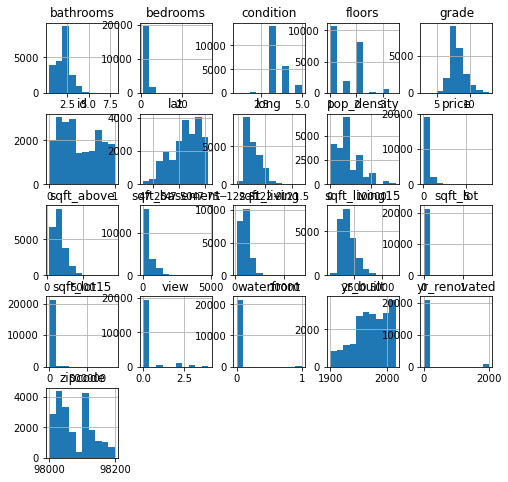

In [21]:
#histogram of the columns 
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
df.hist(ax = ax);

In [22]:
lr_df = df.copy() 

In [23]:
lr_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,4966
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,6879
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,3606
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,6425
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2411


In [24]:
lr_df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'pop_density'],
      dtype='object')

In [25]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'pop_density'],
      dtype='object')

## Label Encode "yr_built" 
I am going to encode the yr_built column into three values 1900-1950, 1950-2000, 2000-2015 this will hopefully add more meaning to the yr_built column in the ols model?

In [26]:
#create dummy categories 
yrs = ['Before 1950', 'Between 1950-2000', 'After 2000']
yrs_series = pd.Series(yrs)

In [27]:
#set values as string
yrs_origin = yrs_series.astype('category')
yrs_origin

0          Before 1950
1    Between 1950-2000
2           After 2000
dtype: category
Categories (3, object): [After 2000, Before 1950, Between 1950-2000]

In [28]:
#assign to dataframe 
lr_df["yr_built"] = lr_df["yr_built"].map(lambda x: '0' if x < 1950 else ('2' if x > 2000  else '1'))

In [29]:
lr_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1,0.0,98178,47.5112,-122.257,1340,5650,4966
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1,1991.0,98125,47.7210,-122.319,1690,7639,6879
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,0,0.0,98028,47.7379,-122.233,2720,8062,3606
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1,0.0,98136,47.5208,-122.393,1360,5000,6425
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1,0.0,98074,47.6168,-122.045,1800,7503,2411


## Dummify "yr_renovated" 
I am going to dummify this to either it has been renovated or it hasn't. This should help account for the vast majority of 0 values in the columnm. Only 744 of the houses had a value for this which is only 3% of the data set.

In [30]:
df.loc[df['yr_renovated'] != 0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,6879
35,9547205180,2014-06-13,696000.0,3,2.50,2300,3060,1.5,0.0,0.0,...,1510,790.0,1930,2002.0,98115,47.6827,-122.310,1590,3264,7018
95,1483300570,2014-09-08,905000.0,4,2.50,3300,10250,1.0,0.0,0.0,...,2390,910.0,1946,1991.0,98040,47.5873,-122.249,1950,6045,3591
103,2450000295,2014-10-07,1090000.0,3,2.50,2920,8113,2.0,0.0,0.0,...,2920,0.0,1950,2010.0,98004,47.5814,-122.196,2370,8113,3977
125,4389200955,2015-03-02,1450000.0,4,2.75,2750,17789,1.5,0.0,0.0,...,1980,770.0,1914,1992.0,98004,47.6141,-122.212,3060,11275,3977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19602,6392000625,2014-07-12,451000.0,2,1.00,900,6000,1.0,0.0,0.0,...,900,0.0,1944,2004.0,98115,47.6855,-122.289,1460,4800,7018
20041,126039256,2014-09-04,434900.0,3,2.00,1520,5040,2.0,0.0,0.0,...,1520,0.0,1977,2006.0,98177,47.7770,-122.362,1860,8710,3341
20428,4305600360,2015-02-25,500012.0,4,2.50,2400,9612,1.0,0.0,0.0,...,1230,1170.0,1962,2009.0,98059,47.4799,-122.127,2430,5539,1725
20431,3319500628,2015-02-12,356999.0,3,1.50,1010,1546,2.0,0.0,0.0,...,1010,0.0,1971,2014.0,98144,47.5998,-122.311,1010,1517,7895


In [31]:
#map a 1 if renovated 0 if not 
lr_df['yr_renovated'] = lr_df['yr_renovated'].map(lambda x: '1' if x < 1 else '0')

In [32]:
#check data has been dummified 
lr_df['yr_renovated'].unique()

array(['1', '0'], dtype=object)

In [33]:
lr_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1,1,98178,47.5112,-122.257,1340,5650,4966
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1,0,98125,47.7210,-122.319,1690,7639,6879
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,0,1,98028,47.7379,-122.233,2720,8062,3606
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1,1,98136,47.5208,-122.393,1360,5000,6425
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1,1,98074,47.6168,-122.045,1800,7503,2411


## Dummify "Zipcode" 
Dummify the zipcode columns into groupings that are inside and outside of the city limits I found the city border
<a href="https://www.usmapguide.com/washington/seattle-zip-code-map">here</a> this will allow me to group the zipcodes without splitting up my data too much 

In [34]:
#unique zipcodes 
df['zipcode'].unique() 

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039], dtype=int64)

In [35]:
#inside city line
options = [98155, 98177, 98133, 98125, 98117, 98103, 98115, 98105, 98102, 98112, 98109, 98107, 98119, 
           98199, 98122, 98144, 98134, 98108, 98118, 98168, 98106, 98126, 98136, 98116, 98146, 98178, 98121,
           98101, 98154, 98104] 
seattle_proper = df[df['zipcode'].isin(options)] 

In [36]:
#breaking up zipcode by seattle city limits  
#outside city line
non_city_options = [98028, 98074, 98053, 98003, 98198, 98038, 98007, 98019, 98002, 98040, 98092, 98030, 98052, 98027, 98058, 
98001, 98056, 98166, 98023, 98070, 98148, 98042, 98008, 98059, 98004, 98005, 98034, 98075, 98010, 98032, 98045, 98077,  
98065, 98029, 98006, 98022, 98033, 98024, 98011, 98031, 98072, 98188, 98014, 98055, 98039]
burbs = df[df['zipcode'].isin(non_city_options)]   

In [37]:
dic = {zipcode[i]: pop_density[i] for i in range(len(zipcode))}  

def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 

event_dictionary = {98155: 'city', 98177: 'city', 98133: 'city', 98125: 'city', 98117: 'city', 98103: 'city', 98115: 'city',
                    98105: 'city', 98102: 'city', 98112: 'city', 98109: 'city', 98107: 'city', 98119: 'city', 98199: 'city',
                    98122: 'city', 98144: 'city', 98134: 'city', 98108: 'city', 98118: 'city', 98168: 'city', 98106: 'city',
                    98126: 'city', 98136: 'city', 98116: 'city', 98146: 'city', 98178: 'city', 98121: 'city', 98101: 'city',
                    98154: 'city', 98104: 'city', 98028: 'notcity', 98074: 'notcity', 98053: 'notcity', 98003: 'notcity', 
                    98198: 'notcity', 98038: 'notcity', 98007: 'notcity', 98019: 'notcity', 98002: 'notcity', 98040: 'notcity',
                    98092: 'notcity', 98030: 'notcity', 98052: 'notcity', 98027: 'notcity', 98058: 'notcity', 98001: 'notcity', 
                    98056: 'notcity', 98166: 'notcity', 98023: 'notcity', 98070: 'notcity', 98148: 'notcity', 98042: 'notcity', 
                    98008: 'notcity', 98059: 'notcity', 98004: 'notcity', 98005: 'notcity', 98034: 'notcity', 98075: 'notcity', 
                    98010: 'notcity', 98032: 'notcity', 98045: 'notcity', 98077: 'notcity', 98065: 'notcity', 98029: 'notcity',
                    98006: 'notcity', 98022: 'notcity', 98033: 'notcity', 98024: 'notcity', 98011: 'notcity', 98031: 'notcity', 
                    98072: 'notcity', 98188: 'notcity', 98014: 'notcity', 98055: 'notcity', 98039: 'notcity'} 
lr_df['city'] = lr_df['zipcode'].apply(set_value, args=(event_dictionary, )) 

In [38]:
#set city to 0 and notcity to 1 
lr_df['city'] = lr_df['city'].map(lambda x: '0' if x == "city" else '1')

In [39]:
#check to make sure dummy updated 
lr_df['city'].unique()

array(['0', '1'], dtype=object)

In [40]:
#track df
lr_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,0.0,1,1,98178,47.5112,-122.257,1340,5650,4966,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,400.0,1,0,98125,47.7210,-122.319,1690,7639,6879,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0.0,0,1,98028,47.7379,-122.233,2720,8062,3606,1
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,910.0,1,1,98136,47.5208,-122.393,1360,5000,6425,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0.0,1,1,98074,47.6168,-122.045,1800,7503,2411,1


# Remove Outliers  
Remove any values 3 standard deviations above the mean 

In [41]:
#drop date column 
lr_df = lr_df.drop(['date'], axis=1)

In [42]:
lr_df.dtypes

id                 int64
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront       float64
view             float64
condition          int64
grade              int64
sqft_above         int64
sqft_basement    float64
yr_built          object
yr_renovated      object
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
pop_density        int64
city              object
dtype: object

##### Data Decision Analysis 
Assuming that the definiton of a full or "1.0" bathroom is that is has a sink, toliet, and shower (3 appliances) I am assuming that each of these whole bathrooms is correlated to a bedroom. In order to reduce the multicolinearity of these two columns I am going to leave only the .50 (just toliet and sink) and .25 (just sink) values in the column to indicate a value of bathrooms that are in addition to the bedroom bathroom.

In [43]:
#resent dtype on encoded columns
lr_df['yr_renovated'] = lr_df['yr_renovated'].astype('float64') 
lr_df['city'] = lr_df['city'].astype('int64') 
lr_df['yr_built'] = lr_df['yr_built'].astype('int64')

In [44]:
lr_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0.0,1,1.0,98178,47.5112,-122.257,1340,5650,4966,0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,400.0,1,0.0,98125,47.7210,-122.319,1690,7639,6879,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0.0,0,1.0,98028,47.7379,-122.233,2720,8062,3606,1
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,910.0,1,1.0,98136,47.5208,-122.393,1360,5000,6425,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0.0,1,1.0,98074,47.6168,-122.045,1800,7503,2411,1


In [45]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,4966
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,6879
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062,3606
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000,6425
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503,2411


In [47]:
 lr_df.drop(['id'], axis=1)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,...,0.0,1,1.0,98178,47.5112,-122.257,1340,5650,4966,0
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,...,400.0,1,0.0,98125,47.7210,-122.319,1690,7639,6879,0
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,...,0.0,0,1.0,98028,47.7379,-122.233,2720,8062,3606,1
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,...,910.0,1,1.0,98136,47.5208,-122.393,1360,5000,6425,0
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,...,0.0,1,1.0,98074,47.6168,-122.045,1800,7503,2411,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,...,0.0,2,1.0,98103,47.6993,-122.346,1530,1509,9905,0
21593,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,...,0.0,2,1.0,98146,47.5107,-122.362,1830,7200,5573,0
21594,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,...,0.0,2,1.0,98144,47.5944,-122.299,1020,2007,7895,0
21595,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,...,0.0,2,1.0,98027,47.5345,-122.069,1410,1287,469,1


In [48]:
#look at z scores (relationship to the std & mean) 
z = np.abs(stats.zscore(lr_df)) 
threshold = 3 #3 std away from them mean
print(np.where(z > 3))

(array([    1,     5,     5, ..., 21574, 21574, 21584], dtype=int64), array([14,  3,  4, ..., 12, 18, 11], dtype=int64))


In [49]:
#drop anything outside 3 std 
lr_df = lr_df[(z<3).all(axis=1)]
lr_df.head() 

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0.0,1,1.0,98178,47.5112,-122.257,1340,5650,4966,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0.0,0,1.0,98028,47.7379,-122.233,2720,8062,3606,1
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,910.0,1,1.0,98136,47.5208,-122.393,1360,5000,6425,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0.0,1,1.0,98074,47.6168,-122.045,1800,7503,2411,1
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,...,0.0,1,1.0,98003,47.3097,-122.327,2238,6819,3800,1


# Bedrooms & Bathrooms 
Modify the relationship between bedrooms and bathrooms to reduce multicolinearity

In [50]:
lr_df['bedrooms'].unique()

array([3, 2, 4, 5, 1, 6], dtype=int64)

In [51]:
lr_df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,pop_density,city
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,0.0,1,1.0,98178,47.5112,-122.257,1340,5650,4966,0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,0.0,0,1.0,98028,47.7379,-122.233,2720,8062,3606,1
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,910.0,1,1.0,98136,47.5208,-122.393,1360,5000,6425,0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,0.0,1,1.0,98074,47.6168,-122.045,1800,7503,2411,1
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,...,0.0,1,1.0,98003,47.3097,-122.327,2238,6819,3800,1


In [53]:
lr_df['bathrooms'].unique() 
#lr_df.loc[lr_df['bathrooms'] == 7.75]

array([1.  , 3.  , 2.  , 2.25, 1.5 , 2.5 , 1.75, 2.75, 4.  , 3.25, 3.5 ,
       0.75, 4.25, 3.75, 1.25, 0.5 ])

In [54]:
lr_df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'pop_density', 'city'],
      dtype='object')

In [55]:
#take the sum of bathrooms/bedrooms 
lr_df["bed_bath"] = lr_df['bedrooms'] + lr_df['bathrooms']

# Log Transform 
Transform non normal distributions in the data

In [56]:
lr_df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'pop_density', 'city', 'bed_bath'],
      dtype='object')

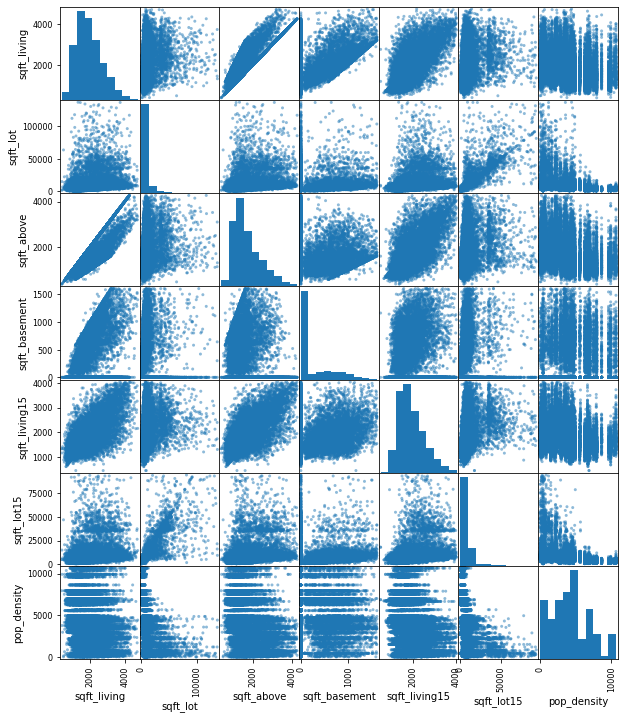

In [57]:
#visulaize distributions  
x_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'pop_density']
pd.plotting.scatter_matrix(lr_df[x_cols], figsize=(10,12));

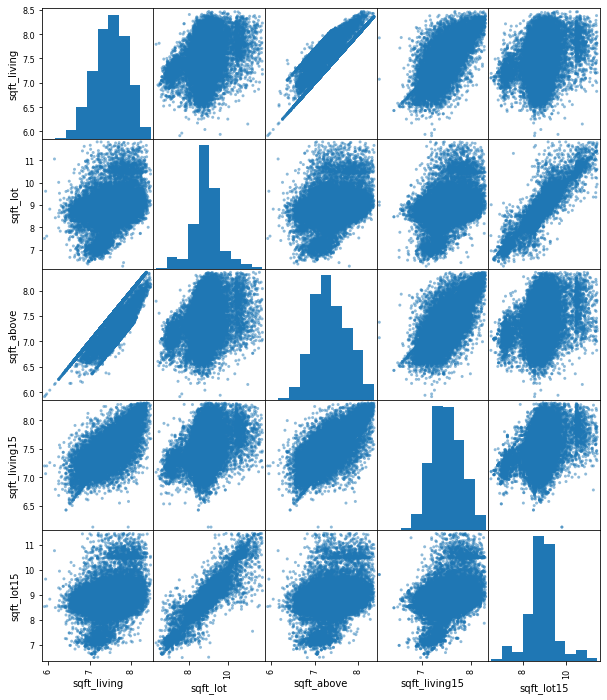

In [58]:
#look just at non normal 
non_normal = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15']
for feat in non_normal:
    lr_df[feat] = lr_df[feat].map(lambda x: np.log(x))
pd.plotting.scatter_matrix(lr_df[non_normal], figsize=(10,12));

In [59]:
ols_df = lr_df.copy()  
%store ols_df

Stored 'ols_df' (DataFrame)
